# cphonon function
### Authors
Written in matlab by Anders Blom, *1999*
Improved by Björn Samuelsson, *2000*
Converted to python Andris Potrebko *2019*

### So, we begin with importing some important libraries

In [383]:
%matplotlib inline
%matplotlib notebook
from matplotlib import pyplot as plt

from scipy.sparse import diags
import numpy as np
from scipy.linalg import eig
import ipywidgets as widgets
from ipywidgets import interact, interactive

from IPython.display import display #Java - not there anymore for running cells from widgits

# For plots being displaied right under the shell
#import scipy as sp

# pretty print all cell's output and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

###Plotly Not sure if works
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import *

### Define some initial values

In [405]:
N = 10
M1 = 1
M2 = 1
C = 1
imp_enabled = 0
Nimp = 5
Mimp = 2
bc = 1

Create force matrix, with 2 on the diagonal and -1 on each side


In [385]:
def CreateForceMatrix(N):
    tmp1 = [-1]*(N-1)
    tmp2 = [2]*N
    diagonals = [tmp1, tmp2, tmp1]  # the diagonals of the force matrix
    A = diags(diagonals, [-1, 0, 1]).todense()
    return(A)
A = CreateForceMatrix(N)

In [386]:
#A

Update the force matrix considering all boundary conditions

In [387]:
def ForceMatrixBoundaryCond(A, bc, N):
    if bc == 2:  # open ends
        A[0, 0] = 1
        A[N-1, N-1] = 1
    elif bc == 1:  # fixed ends
        A[0, 0] = - 2  # this will generate negative eigenvalues, to be removed below
        A[N-1, N-1] = - 2
        A[1, 0] = 0
        A[0, 1] = 0
        A[N - 2, N-1] = 0
        A[N-1, N - 2] = 0
    else:  # periodic boundary cond.
        A[0, N-1] = - 1
        A[N-1, 0] = - 1
    return(A)
A = ForceMatrixBoundaryCond(A, bc, N)

In [388]:
#A

Create mass matrix, take care of impurities

In [389]:
def CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled):
    Nimp = Nimp-1  # Python counts from 0
    B = np.zeros(shape=(N, N))  # diags([1]*N,0).todense()
    for i in range(N):
        if i % 2 == 0:  # if even
            B[i, i] = 1 / M1
        else:
            B[i, i] = 1 / M2

    if imp_enabled:
        B[Nimp, Nimp] = 1 / Mimp
    return(B)
B = CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled)

In [390]:
#B

### Solve the eigenvalue equation
We get *omega* - eigenfrequecies and V - the vector of all displacements *u*

Set number of modes for fixed b.c. this number will be reduced by 2 as we remove negative eigenvalues (Two of the atoms don't move)

In [391]:
def EigenEq(A, B, C, bc, N):
    A1 = np.dot(C*B, A)
    D, V = eig(A1)
    D = np.real(D)
    Nmodes = N
    # Find negative eigenvalues and remove corresponding eigenvectors/-values for fixed b.c
    if bc == 1:
        for k in range(2):
            neg = -1
            for i in range(Nmodes):
                if ((D[i] < -1e-06) & (neg == -1)):
                    neg = i
            D = np.concatenate([D[:(neg)], D[(neg+1):]])
            V = np.concatenate([V[:, :(neg)], V[:, (neg+1):]], axis=1)
            Nmodes = Nmodes - 1

    # Abs because D can be slightly negative ex. -6.10622664e-16
    omega = np.sqrt(np.abs(D))
    # sort the eigenvalues and eigenmodes according to the eigenvalues
    ind = np.argsort(omega)
    omega = np.sort(omega)
    V = V[:, ind]

    return(omega, V, Nmodes)
omega, V, Nmodes = EigenEq(A, B, C, bc, N)

In [392]:
# 
# omega
# V
# Nmodes

In [393]:
# take some care if eigenvalue is first or last in vector
# =============================================================================
#             if neg == 1:
#                 D=D[1:]
#                 V=V[1:,:]
#             else:
#                 if neg == Nmodes:
#                     D=D[:(Nmodes - 1)]
#                     V=V[:(Nmodes-1),:]
#                 else:
#                     if neg != 0:
# =============================================================================

### Discrete fourier transform
We use Fast fourier transform algorithm (*fft* function) to implement the discrete fourier transform.
* For the case of *fixed ends* boundary conditions the smallest wave possible can be a wave with the wavelength *2*\(N-1)* - the wave can be antisymetric with the wave outside. This is why we are looking for *2*\(N-1)* wave number, but taking at the end only the first *Nmodes* possible ones.
* For the case of *open ends* - the real periodicity is *2*\N*
* For periodic boundary conditions, the periodicity is *N* but we cut *np.floor(N/2)* <- **?????** 
Ech frequency except zero is doubly degenerate with +K and -K solutions (moving in opposite directions)

Don't get imag of coefficients //Andris **Need to check the open ends if it is symetric**


In [394]:
def FourierTransform(bc, V, N, Nmodes):
    if bc == 2:  # open ended
        wavemax = Nmodes
        Kk = np.fft.fft(V, 2*N, axis=0)
        Kk = Kk[:int(wavemax) + 1, :Nmodes]
        Ksq = np.real(Kk*np.conj(Kk))
        Karg = np.angle(Kk)
    elif bc == 1:  # fixed imaginary part turns out to work better. Still don't get why
        wavemax = Nmodes
        Kk = np.imag(np.fft.fft(V, 2*(N - 1), axis=0))
        Kk = Kk[:wavemax + 1, :Nmodes]
        Ksq = Kk*Kk
        Karg = 'NA'
        # Karg=Na
    else:  # periodic
        wavemax = np.floor(N / 2)
        Kk = np.fft.fft(V, N, axis=0)
        Kk = Kk[:int(wavemax) + 1, :Nmodes]
        Ksq = np.real(Kk*np.conj(Kk))  # can be a bit negative
        Karg = np.angle(Kk)

    Ka = np.argmax(Ksq, axis=0)
    # mx=np.max(Ksq,axis=0)#this one we don't need
    return(Ka, Karg)  # maybe Kk,
Ka, Karg = FourierTransform(bc, V, N, Nmodes)

In [395]:
# Ka
# Karg

In [396]:
# Ksq1=np.imag(Kk)*np.imag(Kk)
# Ksq2=np.real(Kk*np.conj(Kk))

# plt.plot(Ksq1[:,0])
# plt.plot(Ksq2[:,0])

# #plt.plot(np.imag(Ksq1[:,1]))
#plt.plot(np.imag(Ksq2[:,1]))
#plt.plot(np.real(Ksq1[:,1]))
#plt.plot(np.real(Ksq2[:,1]))

In [397]:
# %%capture 
# fig, ax = plt.subplots();
# #wavemax=np.floor(N / 2)
# Ksq=Kk*Kk
# ax.plot(np.real(Ksq[:,1]))
# ax.plot(np.real(Ksq[:,2]))
# #ax.plot(np.real(V[:,1]))
# #ax.plot(np.real(V[:,2]))
# fig

In [398]:
# plt.plot(Ksq[:,])

In [399]:
#a=[5,6,7]

In [400]:
#np.isnan(a.any())

###Bunch of boring but important manipulations with the results.
* For periodic boundary conditions we have doubly degenerate levels. If we have degenerate levels: give that one with the smallest phase angle a plus sign and the other a minus sign.
* *Ka* values from the fft are only positive. Here we correct the signs filling up the dispersion plot
* Give the corect amplitude for *Ka*

In [401]:
# set Ka to the index of the biggest squared coefficient
def CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N):
    if not(Nmodes):  # if Nmodes = 0 (case when bc=1 and N=2) gives an error
        maxi = 0
    else:
        maxi = np.argmax(Ka)

    if bc == 0:
        for j in range(Nmodes-1):
            if np.abs(omega[j] - omega[j + 1]) < 1e-06:  # if both omegas "almost"" equal
                v1 = Karg[Ka[j], j]
                v2 = Karg[Ka[j+1], j + 1]
                diff = v2 - v1
                if diff < - np.pi:
                    diff = diff + 2*np.pi
                elif diff > np.pi:
                    diff = diff - 2*np.pi
                # those where maxi+1 is even Ka will be -Ka, see below in this sec.
                if diff > 0 or not((maxi+1) % 2 < 0):
                    V[:, j] = - V[:, j]
                if np.abs(np.abs(diff) - np.pi / 2) > 1e-06:
                    # make them both orthonormal (supposes normated vectors)
                    V[:, j + 1] = V[:, j + 1] - V[:, j] * \
                        np.dot(V[:, j + 1], V[:, j])
                    V[:, j + 1] = V[:, j + 1] / \
                        np.sqrt(np.dot(V[:, j + 1], V[:, j + 1]))

    # Change sigh of every second Ka, depending on which is the maximum Ka
    Ka[(maxi) % 2::2] = -Ka[(maxi) % 2::2]

    # set correct magnitude of Ka
    if bc == 1:
        Ka = Ka*np.pi / (N - 1)
    else:
        Ka = Ka*2*np.pi / N

    # The high Ka values () belong to
    if M1 != M2:
        Ka = Ka*2

        for i in range(Nmodes):
            if np.abs(Ka[i]) > np.pi:
                Ka[i] = np.sign(Ka[i])*(np.abs(Ka[i]) - 2*np.pi)

    # correct sign if the last Ka is on the right boundary to the left side (we define our interval of Ka: [-pi/a, pi/a) )
    for i in range(Nmodes):
        if np.abs(Ka[i] - np.pi) < 1e-06:
            Ka[i] = - Ka[i]
    return(V, omega, Ka)
V, omega, Ka = CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N)

### set amplitude proportional to classical amplitude of one excitation

In [382]:
def CorrectAmplitude(V, omega, C, N):
    Vdiff = V[:(N-1), :]-V[1:N, :]
    if bc == 0:
        Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))

    Vdiff = V[:(N-1), :]-V[1:N, :]
    if bc == 0: #Maybe if bc!=1, to incude open ends
        Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))
    Vdiff = np.diag(np.dot(np.transpose(Vdiff), Vdiff)).copy()

    if Nmodes != 0:  # Otherwise it gives error, because no such element
        if Vdiff[0] < 1e-06:
            Vdiff[0] = 1

    Ch = 4*np.sqrt(2*omega / (C*Vdiff))  
    V = np.dot(V, diags(Ch, 0).todense())
    return(V)


V = CorrectAmplitude(V, omega, C, N)

In [298]:
# Vdiff = V[:(N-1), :]-V[1:N, :]
# if bc == 0:
#     Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))

# Vdiff = V[:(N-1), :]-V[1:N, :]
# if bc == 0: #Maybe if bc!=1, to incude open ends
#     Vdiff = np.vstack((Vdiff[:(N-1), :], V[(N-1), :] - V[0, :]))
# Vdiff = np.diag(np.dot(np.transpose(Vdiff), Vdiff)).copy()

# if Nmodes != 0:  # Otherwise it gives error, because no such element
#     if Vdiff[0] < 1e-06:
#         Vdiff[0] = 1
# Ch = 4*np.sqrt(2*omega / (C*Vdiff))

### Analytic solution of the dispersion relation

In [299]:
# %%capture
# capture - so that the plot does not get displayed


The guy bellow (function) plots dispersion plot from both data and the theoretical calculations

In [300]:
def PlotDisp(C, M1, M2, omega, Ka, ax1,ModeNr):
    #global ax1
    ax1.cla()
    ax1.plot(Ka, omega, 'bo', label='simulation')
    
    #Ephesise the chosen point to plot the eigenmode
    SizeChosenP=16-N/20 #If there are many points on the plot then the marker is too big
    try:
        ax1.plot(Ka[ModeNr-1],omega[ModeNr-1],'rx',markersize=SizeChosenP)
        ax1.plot(Ka[ModeNr-1],omega[ModeNr-1],'ro',fillstyle='none',markersize=SizeChosenP)
    except:
        pass

    ka = np.linspace(-np.pi, np.pi, 100)
    if M1 == M2:
        analytic = np.sqrt(4*C/M1)*np.abs(np.sin(ka/2))
        ax1.plot(ka, analytic, label='analytic')
    else:
        MM = (M1+M2)/(M1*M2)
        analytic1 = np.sqrt(
            C*MM * (1 + np.sqrt(1-2/MM/(M1+M2)*(1-np.cos(ka)))))
        analytic2 = np.sqrt(
            C*MM * (1 - np.sqrt(1-2/MM/(M1+M2)*(1-np.cos(ka)))))
        ax1.plot(ka, analytic1, label='analytic acustic')
        ax1.plot(ka, analytic2, label='analytic optical')
    ax1.legend()
    ax1.set(xlabel='k*a',ylabel='frequency, arb.u', title='dispersion relation/allowed vibrational frequencies')

    
#fig, ax1 = plt.subplots()
#PlotDisp(C,M1,M2, omega, Ka,ax1,1)

This guy plots dispacements at one specific given eigenmode

In [301]:
def PlotEigenmode(V, ModeNr, M1, M2, ax2, imp_enabled, Mimp, Nimp):
    #fig, ax = plt.subplots();
    Nmodes=len(V[:, 0])
    ax2.cla()
    if M1 > M2:
        mark1 = 11
        mark2 = 6
    elif M1 == M2:
        mark1 = mark2 = 6
    else:
        mark1 = 6
        mark2 = 11
    marktype = 'bo' if M1 == M2 else 'go'
    oddatoms = range(1, Nmodes+1, 2)
    evenatoms = range(2, Nmodes+1, 2)
    allatoms = range(1, Nmodes+1)
    ax2.set(xlabel='x, atomic spacings',ylabel='displacement, u(t=0), arb.u', title='Instantaneous postitions at one eigenmode')
    if ModeNr==1:
        ax2.set_title('Inst. postitions at one eigenmode',horizontalalignment='left')
    ax2.plot(oddatoms, V[::2, ModeNr-1], 'bo', markersize=mark1)
    ax2.plot(evenatoms, V[1::2, ModeNr-1], marktype, markersize=mark2)
    ax2.plot(allatoms, V[:, ModeNr-1], '-y')
    if imp_enabled == 1:
        ax2.plot(Nimp, V[Nimp-1, ModeNr-1], 'wo', markersize=11)
        ax2.plot(Nimp, V[Nimp-1, ModeNr-1], 'ro', markersize=np.log(Mimp/M1+1.7)*7)

In [302]:
def PlotEigenmodeFixedN2(V, M1, M2, ax2, imp_enabled, Mimp, Nimp):
    oddatoms=1
    evenatoms=2
    ax2.cla()
    if M1 > M2:
        mark1 = 11
        mark2 = 6
    elif M1 == M2:
        mark1 = mark2 = 6
    else:
        mark1 = 6
        mark2 = 11
    marktype = 'bo' if M1 == M2 else 'go'
    allatoms=[1,2]
    ax2.set(xlabel='x, atomic spacings',ylabel='displacement, u(t=0), arb.u', title='Instantaneous postitions at one eigenmode')
    ax2.plot(oddatoms, 0, 'bo', markersize=mark1)
    ax2.plot(evenatoms, 0, marktype, markersize=mark2)
    ax2.plot(allatoms, [0,0], '-y')
    if imp_enabled == 1:
        ax2.plot(Nimp, 0, 'wo', markersize=11)
        ax2.plot(Nimp, 0, 'ro', markersize=np.log(Mimp/M1+1.7)*7)
    

### Here we begin the user interface (UI) part using *widgets* :)

Import some missing libraries and define a function which will calculate $\omega$ and $K_a$ (do everything above) every time some of the main input widgets will be changed. Function *interactive* also defines these widgets.

In [303]:
from ipywidgets import Label, HBox, Layout

Before the definition of the function we also define plots which will be called later. For some buggy reason, the *matplotlib* has to be imported and "*%matplotlib notebook*" has to be called again

In [252]:
%%capture
from matplotlib import pyplot as plt
%matplotlib notebook
# calling it a second time may prevent some graphics errors
%matplotlib notebook
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(9.5, 3.5)
#fig2, ax3 = plt.subplots(nrows=1,ncols=1)
# fig2.set_size_inches(10.0, 0.7)
PlotDisp(C,M1,M2, omega, Ka,ax1,2)
PlotEigenmode(**{'V':V,'ModeNr':2,'M1':M1,'M2':M2,"ax2":ax2,'imp_enabled':imp_enabled,'Mimp':Mimp,'Nimp':Nimp})

In [362]:
#Debug=widgets.HTMLMath(value='Start',placeholder='Some HTML')
def update(N=N, C=C, bc=bc, M1=M1, M2=M2, imp_enabled=imp_enabled, Nimp=Nimp, Mimp=Mimp, ModeNr=2):
    A = CreateForceMatrix(N)
    A = ForceMatrixBoundaryCond(A, bc, N)
    B = CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled)
    omega, V, Nmodes = EigenEq(A, B, C, bc, N)
    Ka, Karg = FourierTransform(bc, V, N, Nmodes)
    V, omega, Ka = CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N)
    # ax.plot(Ka,omega,'bo',label=['simulation']);
    # fig
    if (len(omega)==0):
        #Debug.value='5'
        omega=float('nan')
        V=float('nan')
        Ka=float('nan')
        PlotDisp(C, M1, M2, omega, Ka, ax1,ModeNr)
        PlotEigenmodeFixedN2(V, M1, M2, ax2, imp_enabled, Mimp, Nimp)
    else:
        #Debug.value='I got printed_4_{}'.format(omega)
        V = CorrectAmplitude(V, omega, C, N)
        PlotDisp(C, M1, M2, omega, Ka, ax1,ModeNr)
        PlotEigenmode(V, ModeNr, M1, M2, ax2, imp_enabled, Mimp, Nimp)
    
    try: 
        len(omega) #Will work if omega is not 'nan'     
        return Ka[ModeNr-1], omega[ModeNr-1], V[:,ModeNr-1]
    except:
        return Ka, omega, V   

#
MyInteraction=interactive(update, N=(2, 100, 1), C=(0.2, 10, 0.2), bc=[('periodic', 0),('fixed ends', 1), ('open ends', 2)],
                          M1=(0.1, 5, 0.1), M2=(0.1, 5, 0.1), imp_enabled=[('impurity disabled', 0), ('impurity enabled', 1)],
                          Nimp=(1, 10, 1), Mimp=(0.1, 5, 0.1),ModeNr=(1, 10, 1))


In [305]:
# N=5
# A = CreateForceMatrix(N)
# A = ForceMatrixBoundaryCond(A, bc, N)
# B = CreateMassMatrix(N, M1, M2, Nimp, Mimp, imp_enabled)
# omega, V, Nmodes = EigenEq(A, B, C, bc, N)
# Ka, Karg = FourierTransform(bc, V, N, Nmodes)
# V, omega, Ka = CorrectOmega(Ka, Karg, Nmodes, V, omega, bc, M1, M2, N)
# V = CorrectAmplitude(V, omega, C, N)
# # ax.plot(Ka,omega,'bo',label=['simulation']);
# # fig

In [306]:
#(len(omega)==0)

In [308]:
#fig

I agree that the bellow is not the prettiest way of doing it but I am not really a  programmer and just learning about widgets. :D So, first we get acces to all widgets in MyInteraction so that it would be more starightforward doing it. Also, delete names (*.description*) of each widget because otherwise it will appear when we print it using *HBox* later. The output looks nicer if the name is defined at *HBox*.

In [354]:
for widg in MyInteraction.children[:-1]:
    widg.description=""
    widg.continuous_update=False
    #widg.style=style

NInter, CInter, bcInter, M1Inter, M2Inter, imp_enabledInter, NimpInter, MimpInter, ModeNrInter = [MyInteraction.children[i] for i in range(9)]

#Change sizes of the two boxes otherwise it is too large
bcInter.layout=Layout(width='80px')
imp_enabledInter.layout=Layout(width='130px')

Here define a widget that will print out the chosen value of $K_a$ and corresponding $\omega$

In [355]:
### Define printing omega and Ka values
OmegaPrint="Frequency \( \omega\) is <b>{}</b> arb.u."
Kprint= "<br> Wave vector \( k \) is <b>{}</b> arb.u."         
PrintValue=widgets.HTMLMath(
    value='',
    #value=OmegaPrint.format(np.round(MyInteraction.result[1],3))+Kprint.format(np.round(MyInteraction.result[0],2)),
    placeholder='Some HTML',
    #description='Some HTML'
)
def updateHTML(*args):
    try:
        PrintValue.value=OmegaPrint.format(np.round(MyInteraction.result[1],3))+Kprint.format(np.round(MyInteraction.result[0],2))
    except:
        PrintValue.value=OmegaPrint.format('No Value')+Kprint.format('No Value')        
for widg in MyInteraction.children:
    widg.observe(updateHTML, 'value')
    


#### Defining additional widgets and functions
First we define a bottom that will make the two masses equal when we press it

In [356]:
MassEqualBtn = widgets.Button(description='Equalize Masses')
def equalize_Masses(btn_object):
    M2Inter.value = M1Inter.value
MassEqualBtn.on_click(equalize_Masses)


Take care that when we have fixed ends, the mode number is N-2
Afterwards, when we have different basses and periodic boundary conditions, N must be even

In [358]:
def updateMaxValues(*args):
    if bcInter.value==1:
        if NInter.value==2: #otherwise gives error that max value is less then min value
            ModeNrInter.min=ModeNrInter.max=0
        else:
            ModeNrInter.max=NInter.value-2
            ModeNrInter.min=1
    else:
        ModeNrInter.max=NInter.value
        ModeNrInter.min=1
    NimpInter.max=NInter.value
    
NInter.observe(updateMaxValues, 'value')
bcInter.observe(updateMaxValues, 'value')

def updateNstep(*args):
    if (M1Inter.value!=M2Inter.value)&(bcInter.value==0):
        NInter.step=2
        NInter.value = NInter.value+1 if NInter.value%2 else NInter.value
    else:
        NInter.step=1

M1Inter.observe(updateNstep, 'value')
M2Inter.observe(updateNstep, 'value')
bcInter.observe(updateNstep, 'value')

In [359]:
#ModeNrInter.max=ModeNrInter.min=0

Define all of the outputs

In [360]:
FirstBox=widgets.HBox([Label('N of atoms'),NInter,Label('Spring constant $\gamma$'),CInter,Label('boundary cond.'), bcInter])
#Player=widgets.HBox([play, slider])
Masses=widgets.HBox([Label('Mass 1 $M_1$'),M1Inter,Label('Mass 2, $M_2$'), M2Inter, MassEqualBtn])
ImpurityBox=widgets.HBox([imp_enabledInter,Label('Mass of imp.'),MimpInter,Label('Atom nr. of imp.'), NimpInter])
ModeNrInterBox=widgets.HBox([Label('Mode number'),ModeNrInter, PrintValue])
Impurity = widgets.Accordion(children=[Masses,ImpurityBox])
Impurity.set_title(0,'Masses') 
Impurity.set_title(1, 'Impurity')

Animation

<IPython.core.display.Javascript object>


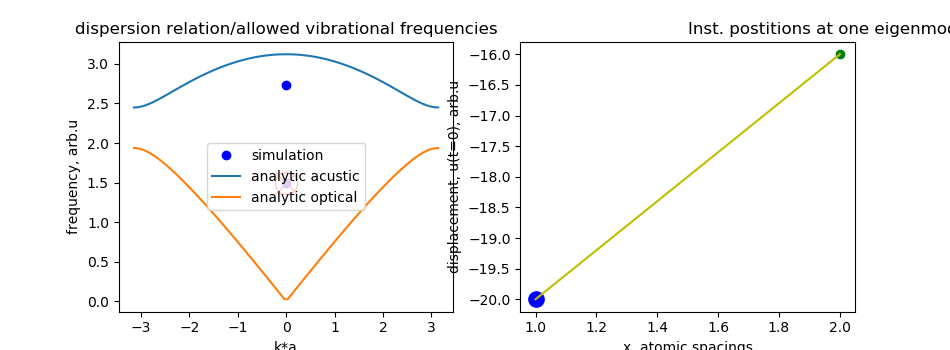

Accordion(children=(HBox(children=(Label(value='Mass 1 $M_1$'), FloatSlider(value=1.0, continuous_update=False…

In [361]:
# fig
# display(FirstBox)
# #display(Masses)
# display(Impurity)
# display(ModeNrInterBox)

In [264]:
#%%capture
from matplotlib import animation, rc
from IPython.display import HTML


Botton which would create an animation if pressed

In [265]:
# plt.rcParams["animation.html"] = "jshtml"
# CreateAnim

In [266]:
# fig
# display(FirstBox)
# #display(Masses)
# display(Impurity)
# display(ModeNrInterBox)

In [267]:
#%matplotlib notebook
#%matplotlib notebook
CreateAnim = widgets.Button(description=r'Create animation')
#CreateAnim = widgets.Button(description=r'Create animation (it will take 10-15seconds)')

outp=widgets.Output(layout={'border': '1px solid black'})
def AnimateOnClick(*args):   
    %run -p Animation.ipynb
    outp.clear_output()
    #display(anim)
    #display(HTML(anim.to_jshtml()))
    with outp:
        display(anim)
CreateAnim.on_click(AnimateOnClick)
CreateAnim.layout=Layout(width='350px',height='60px')

In [268]:
#with outp:
#    display(CreateAnim)
#anim

In [269]:
#outp

In [270]:
# with outp:
#     anim

In [271]:
#outp.clear_output()

In [272]:
#%run -p Untitled-checkpoint.ipynb

Widgets for the animation. *Play* laggs and updates plot only like twice a second which is not what I really like. Found no better solution

In [273]:
# #l=widgets.jslink((MyInteraction.children[0],"value"),(Nreal,"value"))
# play = widgets.Play(
#      interval=10,
#     value=50,
#     min=0,
#     max=100,
#     step=1,
#     description="Press play",
#     disabled=False
# )
# def MakeAnim(change):
#     global x
#     global ax3
#     w=change["new"]
#     ax3.cla()
#     ax3.plot(x,w*np.sin(w * x*0.005))

# x = np.linspace(0, 2 * np.pi)
# ax3.plot(x, np.sin(x))
# slider = widgets.IntSlider()
# widgets.jslink((play, 'value'), (slider, 'value'))
# play.observe(MakeAnim, 'value')

In [274]:
# fig
# display(FirstBox)
# #display(Masses)
# display(Impurity)
# display(ModeNrInterBox)
# #display(FirstBox)
# #display(Masses)
# #display(Impurity)
# #display(ModeNrInterBox)
# #display(CreateAnim)
# #with outp:
# #     display(CreateAnim)
# #outp